In [1]:
# NumPy and odeint, our workhorses
import numpy as np
import scipy.integrate
import scipy
import scipy
import numba 
import pandas as pd
import time
# Plotting modules
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import bioscrape as bs
import bebi103
import corner
import emcee
import numba
import time
import pickle
from cycler import cycler

# Pretty plot settings from Anandh
mpl.font_manager._rebuild()
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})


mpl.rc('axes', prop_cycle=(cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#mpl.rc('text', usetex=False)
#mpl.rc('text.latex', preamble=r'\usepackage{helvet}
#\renewcommand\familydefault{\sfdefault}\usepackage{sansmath}\sansmath')
mpl.rc('font',**{'family':'sans-serif','sans-serif':['Roboto'], 
                 'serif': ['Roboto'],'weight':'normal'})

tw = 1.5
sns.set_style({"xtick.major.size": 3, "ytick.major.size": 3,
               "xtick.minor.size": 2, "ytick.minor.size": 2,
               'axes.labelsize': 14, 'axes.titlesize': 14,
               'xtick.major.width': tw, 'xtick.minor.width': tw,
               'ytick.major.width': tw, 'ytick.minor.width': tw})

mpl.rc('xtick', labelsize=14) 
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', linewidth=1.5)
mpl.rc('legend', fontsize=14)
mpl.rc('figure', figsize=(9,15))


# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

The code is this notebook is for generating the plots in Figure 1E-H. See the jupyter notebook 'latex_equations' the systems of ODEs used for the modeling. All simulations here are down with exponential growth, no-dilution, and no carrying capacity.

In [2]:
def plot_naive(ax, sim_output, t, frac_of_total=True,legend=['producers','non-producers','total']):
    
    sim_trans = sim_output.transpose()
    tot = sim_trans.sum(axis=0)
    
    if frac_of_total:
        denom = tot
        ylab = 'population fraction'
    
    else:
        denom = 1
        ylab = 'cell concentration (cells/mL)'
        
    ax.plot(t,sim_trans[0,:]/denom)
    ax.plot(t,sim_trans[1,:]/denom)
    ax.plot(t,tot/denom,'--',color='black')
    
    ax.set_xlabel('time (days)')
    ax.set_ylabel(ylab)
    ax.legend(legend)
    
    return ax

In [3]:
def plot_differentiation(ax, sim_output, t, frac_of_total=True,legend=['stem cells','non-producers','producers']):
    
    sim_trans = sim_output.transpose()
    tot = sim_trans.sum(axis=0)
    
    if frac_of_total:
        denom = tot
        ylab = 'population fraction'
    
    else:
        denom = 1
        ylab = 'cell concentration (cells/mL)'
        
    ax.plot(t,sim_trans[0,:]/denom)
    ax.plot(t,sim_trans[1,:]/denom)
    ax.plot(t,sim_trans[2,:]/denom)
    ax.plot(t,tot/denom,'--',color='black')
    
    ax.set_xlabel('time (days)')
    ax.set_ylabel(ylab)
    ax.legend(legend)
    
    return ax

In [4]:
def plot_diff_select(ax, sim_output, t, n_div, frac_of_total=True,
                         legend=['$X_{Stem}$','$X_{Diff}$','$X_{Mut}$','total']):
    
    sim_trans = sim_output.transpose()
    tot = sim_trans.sum(axis=0)
    
    diff_tot = sim_trans[3:].sum(axis=0)
    mut_tot = sim_trans[1:3].sum(axis=0)
    if frac_of_total:
        denom = tot
        ylab = 'population fraction'
    
    else:
        denom = 1
        ylab = 'cell concentration (cells/mL)'
        
    ax.plot(t,sim_trans[0,:]/denom)
    ax.plot(t,diff_tot/denom)
    ax.plot(t,mut_tot/denom)
    ax.plot(t,tot/denom,'--',color='black')
    
    ax.set_xlabel('time (days)')
    ax.set_ylabel(ylab)
    ax.legend(legend)
    
    return ax

In [5]:
# Parameters common to all simulations
n_div = 6
mu_P = 0.5
mu_N = 1.5
mu_M = 1.5
mu_SP = 1.5
mu_SN = 1.5
mu_MP = 0.5
mu_MN = 1.5
mu_DPs = np.ones(n_div+1)*0.5
mu_DNs = np.ones(n_div+1)*0.5
lam_diff = 0.1
lam_MB = 1e-6
lam_MD = 1e-6
lam_MS = 1e-6
K = 1e9
D = 0.3
nodiv_prod=False
nodiv_ctot_count=False
production_constant = True
mu_DP_max=1
beta_p=1
V=1
X_SP0=1e6
X_SN0=0
X_MP0=0
X_MN0=0
beta_p=1
V=1
frac_flow_start = 0.95
t = np.linspace(0,24*10,24*100)
# (mu_P, mu_N, lam_diff, lam_MB, lam_MD, K, D, beta_p, V)
# t, mu_SP, mu_SN, mu_MP, mu_MN, mu_DPs, mu_DNs, lam_diff, lam_MB, lam_MD, 
#                         lam_MS, K, n_div, D, nodiv_prod=False, nodiv_ctot_count=False, production='constant',
#                         mu_DP_max=1, beta_p=1, V=1, X_SP0=1e6, X_SN0=0, X_MP0=0, X_MN0=0


Now we would like to see if and how the performance of the differentiation circuit is in the context of serial dilution in a plate reader experiment. In this context, we can vary both the probability of differentation, as well as the copy number of the R6K plasmid. However, as before, we will independently look at different copy numbers/number of dilutions allowed.

In [6]:
@numba.jit(nopython=True)
def naive_noK(concs, t, mu_P, mu_N, lam_MB):
    """
    Function for solving ODEs for naive implementation.
    Returns np.array([dXP/dt (producers), dXN/dt (non-producers)])
    concs: np.array([producer, non-producer])
    t: time array for ODE solver
    mu_P: specific growth rate of producers (1/h)
    mu_N: specific growth rate of non-producers (1/h)
    lam_MB: burden mutation rate (1/h)
    """
    
    # allocate empty array for ddts
    ddts = np.zeros(len(concs))
    
    # stem cells
    ddts[0] = mu_P*concs[0] - lam_MB*concs[0]
    
    # broken stem cells
    ddts[1] = lam_MB*concs[0] + mu_N*concs[1]
    
    return ddts



@numba.jit(nopython=True)
def diff_noK(concs, t, mu_P, mu_N, mu_M, lam_diff, lam_MB, lam_MD):
    """
    Function for solving ODEs for production with differentiation.
    Returns np.array([dXPP/dt (progenitors), dXM/dt (non-producer mutants), dXDP/dt (differentiated producers), dP/dt (protein/production)])
    concs: np.array([producer, non-producer, production])
    t: time array for ODE solver
    mu_P: specific growth rate of producers (1/h)
    mu_N: specific growth rate of progenitor cells/non-producers (1/h)
    mu_M: specific growth rate of mutant non-producers
    lam_diff: differentiation rate (1/h)
    lam_MB: burden mutation rate (1/h)
    lam_MD: differentiation mutation rate (1/h)
    """
    
    # allocate empty array for ddts
    ddts = np.zeros(len(concs))
    
    # total cell population
    ctot = concs[0:3].sum()
    
    ddts[0] = mu_N*concs[0] - lam_diff*concs[0] - (lam_MB+lam_MD)*concs[0]
    
    ddts[1] = mu_M*concs[1] + (lam_MB+lam_MD)*concs[0] +  lam_MB*concs[2]
    
    ddts[2] = mu_P*concs[2] + lam_diff*concs[0] - lam_MB*concs[2]
        
    return ddts

def run_diff_exponential(lam_diffs, mu_P=1, mu_N=1, mu_M=1, lam_MB=0, lam_MD=0, 
                            progenitor_init=1e7, t=np.linspace(0,240,240)):
    """
    Allows simulation of differentiation architecture for multiple differentiation rates.
    Returns concatenated df with output of simulations for all lam_diffs
    """
    lam_diffs_df = []
    progenitor_endcounts_df = []
    diff_endcounts_df = []
    mut_endcounts_df = []
    t_df = []
    
    for j, lam_diff in enumerate(lam_diffs):
        concs = np.array([progenitor_init,0,0])
        out = scipy.integrate.odeint(diff_noK, concs, t, 
                                     args=(mu_P, mu_N, mu_M, lam_diff, lam_MB, lam_MD))
        pop_tots = out.sum(axis=1)
        lam_diffs_df += [lam_diff,]*len(t)
        progenitor_endcounts_df += list(out[:,0]/pop_tots)
        mut_endcounts_df += list(out[:,1]/pop_tots)
        diff_endcounts_df += list(out[:,2]/pop_tots)
        t_df += list(t)
    
    return pd.DataFrame(dict(lam_diff = lam_diffs_df,time=t_df,
                            progenitor = progenitor_endcounts_df, diff = diff_endcounts_df, mut = mut_endcounts_df))

@numba.jit(nopython=True)
def diff_select_noK(concs, t, mu_PP, mu_PN, mu_MP, mu_MN, mu_DPs, mu_DNs, lam_diff, lam_MB, lam_MD, 
                        lam_MS, n_div, nodiv_ctot_count=False):
    """
    Function for solving ODEs for production with terminal differentiation.
    Returns array of d/dts for cell concentrations and production
    Array is in the order: PP, PN, MP, MN, DP(0)...DP(n), DN(0)..DN(n)
        PP: progenitor producer (progenitor cell that will differentiate into a differentiated producer)
        PN: progenitor non-producer
        MP: Mutant producer (producer that will divide indefinitely)
        MN: Mutant non-producer (non-producer that will divide indefiniteley and not differentiate)
        DP(0)...DP(n): Differentiated producers with n-i divisions remaining
        DN(0)...DN(n): Differentiated non-producers with n-i divisions remaining      
    t: time array for ODE solver
    mu_PP: specific growth rate of progenitors that differentiated into producers (1/h)
    mu_PN: specific growth rate of progenitors that differentiated into non-producers (1/h)
    mu_MP: specific growth rate of mutant producers that divide indefinitely (1/h)
    mu_MN: specific growth rate of mutant non-producers that divide indefinitely (1/h)
    mu_DPs: specific growth rates of differentiated producers (1/h)
    mu_DNs: specific growth rates of differentiated non-producers (1/h)
    lam_diff: differentiation rate (1/h)
    lam_MB: burden mutation rate (1/h)
    lam_MD: differentiation mutation rate (1/h)
    lam_MS: selection mutation rate (1/h)
    n_div: number of divisions differentiated cells can undergo
    nodiv_ctot_count: If True, differentiated cells with 0 divisions remaining will count towards total cell count
    """
    
    # allocate empty array for ddts
    ddts = np.zeros(len(concs))
    
    # total cell population
    if nodiv_ctot_count:
        ctot = concs[0:-1].sum()
    else:
        ctot = concs[0:-1].sum() - concs[4+n_div] - concs[5+2*n_div]
    
    # stem cell producers
    ddts[0] = mu_PP*concs[0] - (lam_diff+lam_MB+lam_MD)*concs[0]
    
    # stem cell non-producers
    ddts[1] = mu_PN*concs[1] + lam_MB*concs[0] - (lam_diff+lam_MD)*concs[1]
    
    # mutant producers
    ddts[2] = mu_MP*concs[2] + lam_MS*np.sum(concs[4:4+n_div]) - lam_MB*concs[2]
    
    # mutant non-producers
    ddts[3] = mu_MN*concs[3] + lam_MD*(concs[0]+concs[1]) + lam_MB*concs[2] \
                + lam_MS*(np.sum(concs[5+n_div:5+2*n_div]))
    
    # Differentiated producers with n remaining divisions
    ddts[4] = lam_diff*concs[0] - mu_DPs[0]*concs[4] - (lam_MB+lam_MS)*concs[4]
    
    # Differentiated non-producers with n remaining divisions
    ddts[5+n_div] = lam_diff*concs[1] - mu_DNs[0]*concs[5+n_div] + lam_MB*concs[4] \
                    - lam_MS*concs[5+n_div]
    # Differentiated producers and non-producers with <n remaining cell divisions
    for i in range(n_div):
        if i < (n_div-1):
            ddts[i+5] = 2*mu_DPs[i]*(concs[i+4]) - mu_DPs[i+1]*concs[i+5] \
                            - (lam_MB+lam_MS)*concs[i+5]
            ddts[i+6+n_div] = 2*mu_DNs[i]*(concs[i+5+n_div]) - mu_DNs[i+1]*concs[i+6+n_div] \
                                + lam_MB*concs[i+5] - lam_MS*concs[i+6+n_div]
        # Differentiated cells with no remaining cell divisions
        else:
            ddts[i+5] = 2*mu_DPs[i]*concs[i+4]
            ddts[i+6+n_div] = 2*mu_DNs[i]*(concs[i+5+n_div])

    return ddts

def run_diff_select_exponential(lam_diffs, n_divs, mu_wt=1, burden=0, lam_MB=0, lam_MD=0, 
                            lam_MS=0, progenitor_init=1e7, t=np.linspace(0,240,240),nodiv_ctot_count=False,
                            endpoints_only=False):
    """
    Allows simulation of terminal differentiation architecture for multiple differentiation rates and number
    of division allowed. Returns concatenated df with output of simulations for all combinations of lam_diffs/ndiv
    """   
    lam_diffs_df = []
    n_divs_df = []
    pp_endcounts_df = []
    pn_endcounts_df = []
    mp_endcounts_df = []
    mn_endcounts_df = []
    dp_endcounts_df = []
    dn_endcounts_df = []
    t_df = []
    
    for i, n_div in enumerate(n_divs):
        mu_DPs = np.ones(n_div+1)*mu_wt*(1-burden)
        mu_DPs[-1]=0
        mu_DNs = np.ones(n_div+1)*mu_wt
        mu_DNs[-1]=0
        for j, lam_diff in enumerate(lam_diffs):
            concs = np.concatenate((np.array([progenitor_init,0,0,0]),np.zeros(2*n_div+2)))  
            out = scipy.integrate.odeint(diff_select_noK, concs, t, 
                                         args=(mu_wt, mu_wt, mu_wt*(1-burden), mu_wt, mu_DPs, mu_DNs, lam_diff, 
                                               lam_MB, lam_MD, lam_MS, n_div, False))
            
            if nodiv_ctot_count:
                pop_tots = out.sum(axis=1)
            else:
                pop_tots = out.sum(axis=1)
                pop_tots -= out[:,4+n_div]
                pop_tots -= out[:,5+2*n_div]
            
            if endpoints_only:
                lam_diffs_df += [lam_diff,]
                n_divs_df += [n_div,]
                pp_endcounts_df += [out[-1][0]/pop_tots[-1],]
                pn_endcounts_df += [out[-1][1]/pop_tots[-1],]
                mp_endcounts_df += [out[-1][2]/pop_tots[-1],]
                mn_endcounts_df += [out[-1][3]/pop_tots[-1],]
                dp_endcounts_df += [out[-1][4:4+n_div+nodiv_ctot_count].sum()/pop_tots[-1],]
                dn_endcounts_df += [out[-1][5+n_div:5+2*n_div+nodiv_ctot_count].sum()/pop_tots[-1],]
            else:
                lam_diffs_df += [lam_diff,]*len(t)
                n_divs_df += [n_div,]*len(t)
                pp_endcounts_df += list(out[:,0]/pop_tots)
                pn_endcounts_df += list(out[:,1]/pop_tots)
                mp_endcounts_df += list(out[:,2]/pop_tots)
                mn_endcounts_df += list(out[:,3]/pop_tots)
                dp_endcounts_df += list(out[:,4:4+n_div+nodiv_ctot_count].sum(axis=1)/pop_tots)
                dn_endcounts_df += list(out[:,5+n_div:5+2*n_div+nodiv_ctot_count].sum(axis=1)/pop_tots)
                t_df += list(t)
    
    if endpoints_only:
        return pd.DataFrame(dict(lam_diff=lam_diffs_df, n_div=n_divs_df, x_pp=pp_endcounts_df, 
                                 x_pn=pn_endcounts_df, x_mp=mp_endcounts_df, x_mn=mn_endcounts_df,
                                 x_dp=dp_endcounts_df, x_dn=dn_endcounts_df))
        
    else:
        return pd.DataFrame(dict(lam_diff=lam_diffs_df, n_div=n_divs_df, x_pp=pp_endcounts_df, 
                                     x_pn=pn_endcounts_df, x_mp=mp_endcounts_df, x_mn=mn_endcounts_df,
                                     x_dp=dp_endcounts_df, x_dn=dn_endcounts_df, time=t_df))


We will now run the simulations and generate the plot for Figure 1E.

In [7]:
# Run simulations for comparision of differentiation vs. diff + selection 
# at various rates of differentation with no burden
lam_diffs = np.array([0,0.1,0.3,1])
n_divs = np.array([4])
df_diff_select = run_diff_select_exponential(lam_diffs, n_divs)
df_diff = run_diff_exponential(lam_diffs)

In [8]:
df_diff.head()

,diff,lam_diff,mut,progenitor,time
0,0.0,0.0,0.0,1.0,0.000000
1,0.0,0.0,0.0,1.0,1.004184
2,0.0,0.0,0.0,1.0,2.008368
3,0.0,0.0,0.0,1.0,3.012552
4,0.0,0.0,0.0,1.0,4.016736


In [9]:
df_diff_select.head()

,lam_diff,n_div,time,x_dn,x_dp,x_mn,x_mp,x_pn,x_pp
0,0.0,4,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,4,1.004184,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,4,2.008368,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,4,3.012552,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,4,4.016736,0.0,0.0,0.0,0.0,0.0,1.0


/Users/rorywilliams/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rorywilliams/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


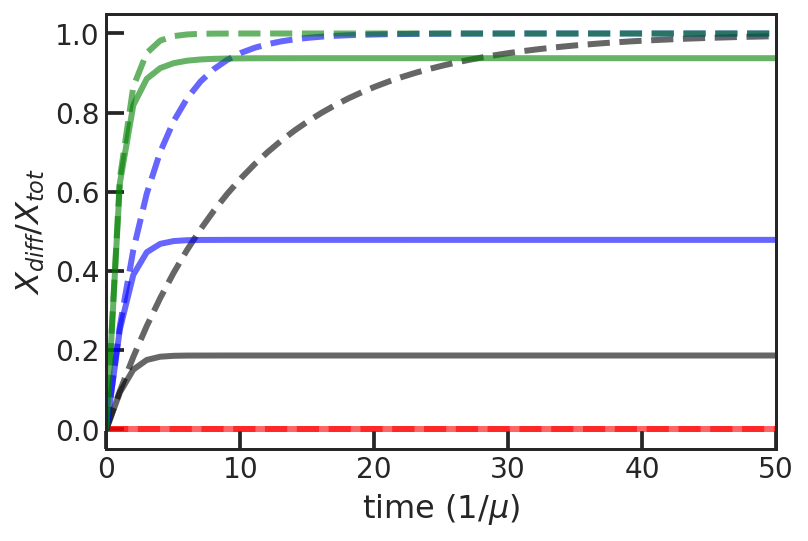

In [10]:
n_div = 4
fig, ax = plt.subplots()
color_palette = sns.color_palette("BuGn_r")[:]
for i, lam_diff in enumerate(lam_diffs):
    # Plot differentiated fraction from differentiation architecture
    x = df_diff.loc[df_diff.lam_diff==lam_diff,'time'].values
    diff = df_diff.loc[df_diff.lam_diff==lam_diff,'diff'].values 
    ax.plot(x,diff,'--',color=sns.color_palette()[i],alpha=0.6,linewidth=3)
    
    # Plot differentiated producers (all differentiated cells when no mutations) for terminal differentiation
    x = df_diff_select.loc[(df_diff_select.n_div==n_div) & (df_diff_select.lam_diff==lam_diff),'time'].values
    x_dp = df_diff_select.loc[(df_diff_select.n_div==n_div) & (df_diff_select.lam_diff==lam_diff),'x_dp'].values 
    ax.plot(x,x_dp,'-',color=sns.color_palette()[i],alpha=0.6,linewidth=3)
ax.set_xlabel('time ($1/\mu$)',fontsize=16)
ax.set_ylabel('$X_{diff}/X_{tot}$',fontsize=16)
ax.set_xlim(0,50)
plt.savefig('./diff_vs_select_noburden.pdf')

/Users/rorywilliams/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


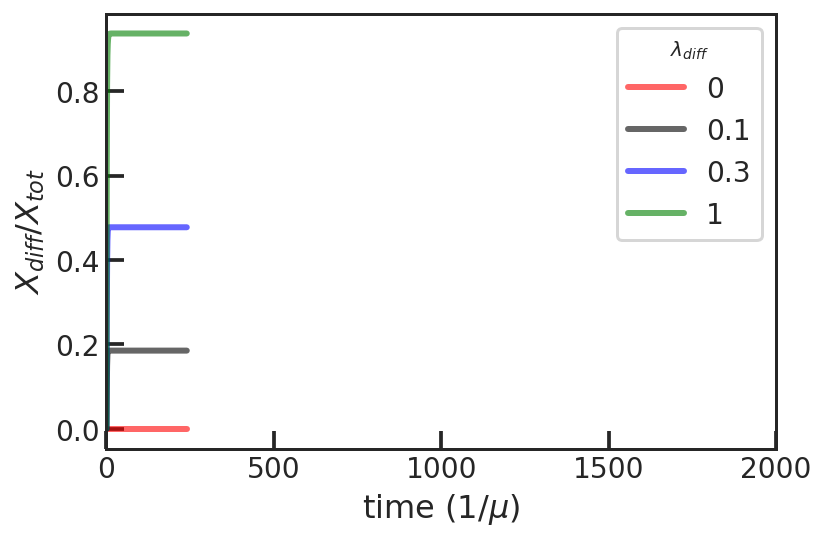

In [11]:
# Plot with legend for differentiation rate
n_div = 4
fig, ax = plt.subplots()
color_palette = sns.color_palette("BuGn_r")[:]
for i, lam_diff in enumerate(lam_diffs):
    # Plot differentiated producers (all differentiated cells when no mutations) for terminal differentiation
    x = df_diff_select.loc[(df_diff_select.n_div==n_div) & (df_diff_select.lam_diff==lam_diff),'time'].values
    x_dp = df_diff_select.loc[(df_diff_select.n_div==n_div) & (df_diff_select.lam_diff==lam_diff),'x_dp'].values 
    ax.plot(x,x_dp,'-',color=sns.color_palette()[i],alpha=0.6,linewidth=3)
ax.set_xlabel('time ($1/\mu$)',fontsize=16)
ax.set_ylabel('$X_{diff}/X_{tot}$',fontsize=16)
ax.set_xlim(0,2000)
# ax.set_xlim(0,50)
ax.legend(['0','0.1','0.3','1'],title='$\lambda_{diff}$')
plt.savefig('./diff_vs_select_noburden_legend1.pdf')

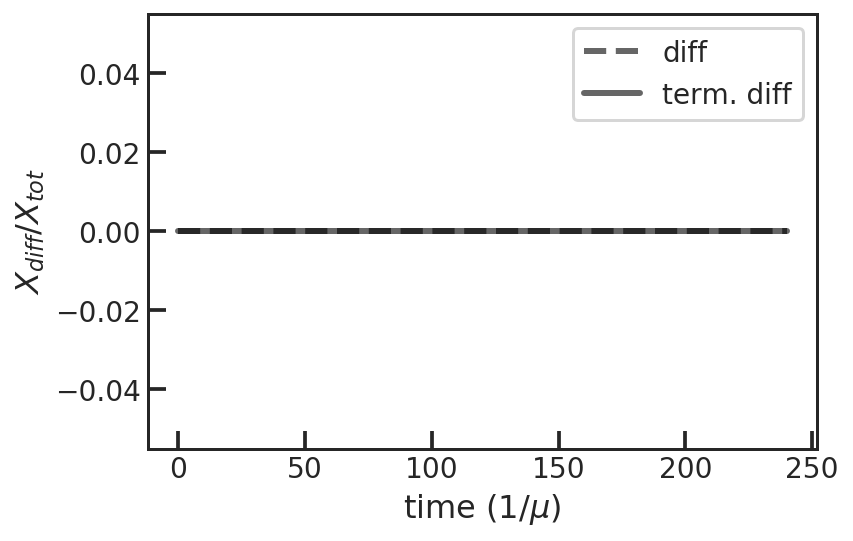

In [12]:
# plot with legend for diff vs. terminal differentiation
n_div = 4
lam_diff = 0
color_palette = sns.color_palette("BuGn_r")[:]

fig, ax = plt.subplots()

# Plot diff
x = df_diff.loc[df_diff.lam_diff==lam_diff,'time'].values
diff = df_diff.loc[df_diff.lam_diff==lam_diff,'diff'].values 
ax.plot(x,diff,'--',color='black',alpha=0.6,linewidth=3)

# Plot terminal diff
x = df_diff_select.loc[(df_diff_select.n_div==n_div) & (df_diff_select.lam_diff==lam_diff),'time'].values
x_dp = df_diff_select.loc[(df_diff_select.n_div==n_div) & (df_diff_select.lam_diff==lam_diff),'x_dp'].values 
ax.plot(x,diff,'-',color='black',alpha=0.6,linewidth=3)
ax.set_xlabel('time ($1/\mu$)',fontsize=16)
ax.set_ylabel('$X_{diff}/X_{tot}$',fontsize=16)

# Legend
ax.legend(['diff','term. diff'])

# Save fig
plt.savefig('./diff_vs_select_noburden_legend2.pdf')


We will now run the simulations and generate the heatmap for Figure 1F:

In [13]:
# Run simulations to look at fraction of stem cells across grid of ndiv and lamdiff
lam_diffs = np.linspace(0,1,11)
lam_diffs = np.round(lam_diffs,1)
n_divs = np.arange(1,11)
df_diff_select_grid = run_diff_select_exponential(lam_diffs, n_divs,endpoints_only=True)

In [14]:
df_diff_select_grid.head()

,lam_diff,n_div,x_dn,x_dp,x_mn,x_mp,x_pn,x_pp
0,0.0,1,0.0,0.00,0.0,0.0,0.0,1.00
1,0.1,1,0.0,0.05,0.0,0.0,0.0,0.95
2,0.2,1,0.0,0.10,0.0,0.0,0.0,0.90
3,0.3,1,0.0,0.15,0.0,0.0,0.0,0.85
4,0.4,1,0.0,0.20,0.0,0.0,0.0,0.80


In [15]:
# Generate pivot table to allow plotting a heatmap
df_grid = df_diff_select_grid.pivot('lam_diff','n_div','x_dp')

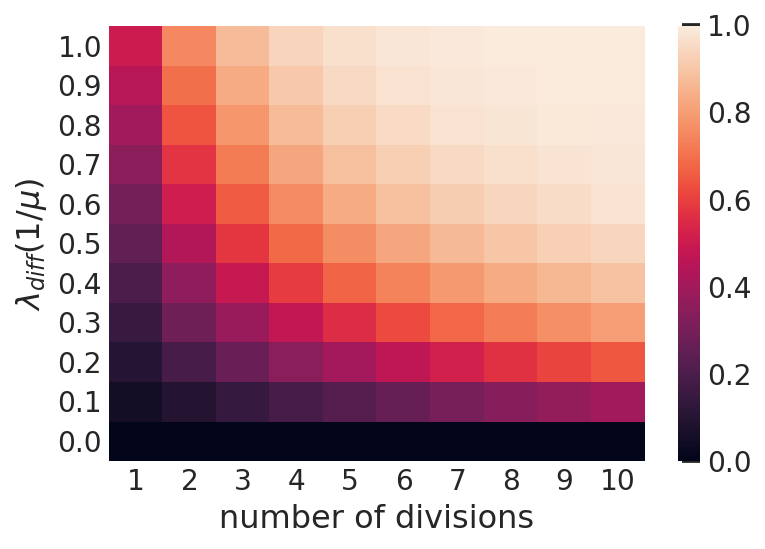

In [16]:
# Plot heatmap
fig, ax = plt.subplots()
sns.heatmap(df_grid)
ax.set_xlabel('number of divisions',fontsize=16)
ax.set_ylabel('$\lambda_{diff} (1/\mu)$ ',fontsize=16)
ax.invert_yaxis()
plt.savefig('./diff_select_ndiv_lamdiff_heatmap.pdf')

We will now run the simulations and generate the plot for Figure 1G:

/Users/rorywilliams/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


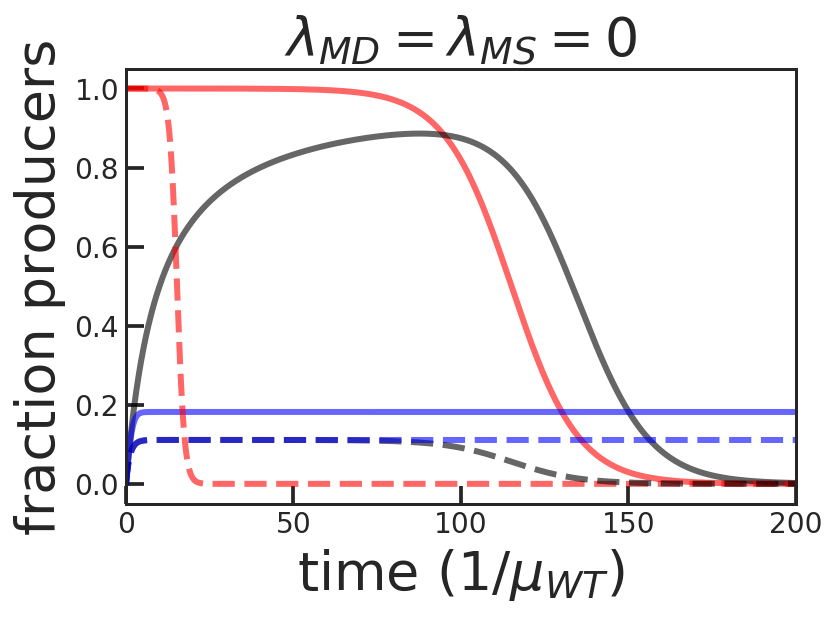

In [17]:
# Run simulations to compare naive vs. diff vs. diff+select without differentiation or selection mutations

# Parameters and starting conditions
progenitor_init = 1e7
t = np.linspace(0,24*10,24*100)
lam_diff = 0.1
n_div = 4
lam_MB = 1e-6
lam_MD = 0
lam_MS = 0
naive_c0 = np.array([progenitor_init,0])
diff_c0 = np.array([progenitor_init,0,0])
ds_c0 = np.concatenate((np.array([progenitor_init,0,0]),np.zeros(n_div+1)))

# Low burden specific parameters
mu_wt = 1
burden = 0.1
mu_N = mu_wt
mu_M = mu_wt
mu_P = mu_wt*(1-burden)




# Run simulations for low burden case for naive, differentiation, and terminal differentiation
naive_out_lowB = scipy.integrate.odeint(naive_noK, np.array([progenitor_init,0]), t, args=(mu_P, mu_N, lam_MB))
diff_out_lowB = run_diff_exponential(np.array([lam_diff]), mu_P=mu_P, mu_N=mu_N, mu_M=mu_M,lam_MB=lam_MB,
                                    lam_MD=lam_MD,progenitor_init=progenitor_init,t=t)

ds_out_lowB = run_diff_select_exponential(np.array([lam_diff]), np.array([n_div]), mu_wt=mu_wt, burden=burden, 
                                          lam_MB=lam_MB, lam_MD=lam_MD, lam_MS=lam_MS, progenitor_init=progenitor_init, 
                                          t=t,nodiv_ctot_count=False,endpoints_only=False)
# Plot low-burden simulations
fig, ax = plt.subplots()
ax.plot(t,naive_out_lowB[:,0]/naive_out_lowB.sum(axis=1),color=sns.color_palette()[0],alpha=0.6,linewidth=3)
ax.plot(t,diff_out_lowB['diff'].values,color=sns.color_palette()[1],alpha=0.6,linewidth=3)
ax.plot(t,ds_out_lowB['x_dp'].values+ds_out_lowB['x_mp'].values,color=sns.color_palette()[2],alpha=0.6,linewidth=3)


# High-burden specific parameters
mu_wt = 1
burden = 0.9
mu_N = mu_wt
mu_M = mu_wt
mu_P = mu_wt*(1-burden)
lam_MB = 1e-6

# Run simulations for high burden case for naive, differentiation, and terminal differentiation
naive_out_highB = scipy.integrate.odeint(naive_noK, np.array([progenitor_init,0]), t, args=(mu_P, mu_N, lam_MB))
diff_out_highB = run_diff_exponential(np.array([lam_diff]), mu_P=mu_P, mu_N=mu_N, mu_M=mu_M,lam_MB=lam_MB,
                                    lam_MD=lam_MD,progenitor_init=progenitor_init,t=t)

ds_out_highB = run_diff_select_exponential(np.array([lam_diff]), np.array([n_div]), mu_wt=mu_wt, burden=burden, 
                                          lam_MB=lam_MB, lam_MD=lam_MD, lam_MS=lam_MS, progenitor_init=progenitor_init, 
                                          t=t,nodiv_ctot_count=False,endpoints_only=False)

# Plot high burden simulations
ax.plot(t,naive_out_highB[:,0]/naive_out_highB.sum(axis=1),'--',color=sns.color_palette()[0],alpha=0.6,linewidth=3)
ax.plot(t,diff_out_highB['diff'].values,'--',color=sns.color_palette()[1],alpha=0.6,linewidth=3)
ax.plot(t,ds_out_highB['x_dp'].values+ds_out_highB['x_mp'].values,'--',color=sns.color_palette()[2],alpha=0.6,linewidth=3)

ax.set_xlim(0,200)
ax.set_xlabel('time ($1/\mu_{WT}$)')
ax.set_ylabel('fraction producers')
ax.set_title('$\lambda_{MD}=\lambda_{MS}=0$')
plt.savefig('./diff_vs_ds_noMDMS.pdf')

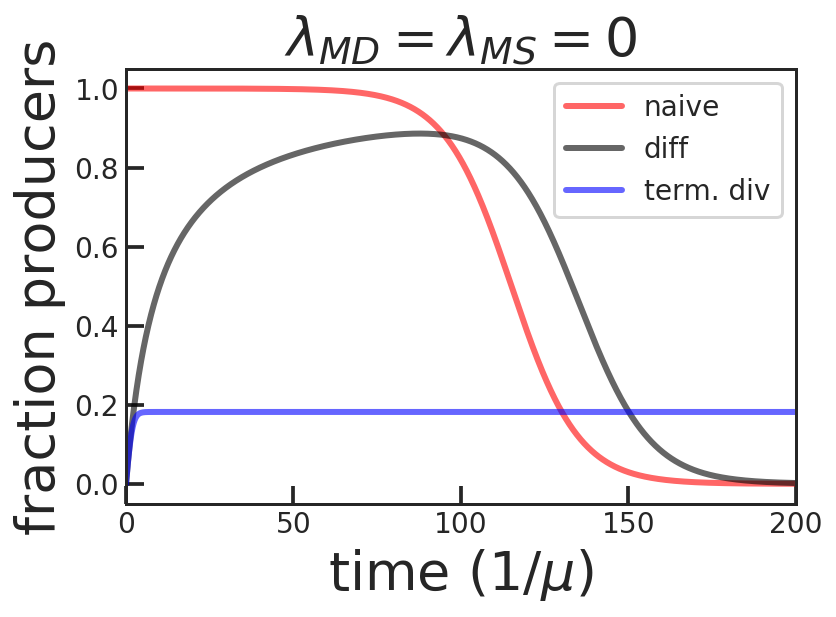

In [18]:
# Plot to get legend for strain type
fig, ax = plt.subplots()
ax.plot(t,naive_out_lowB[:,0]/naive_out_lowB.sum(axis=1),color=sns.color_palette()[0],alpha=0.6,linewidth=3)
ax.plot(t,diff_out_lowB['diff'].values,color=sns.color_palette()[1],alpha=0.6,linewidth=3)
ax.plot(t,ds_out_lowB['x_dp'].values+ds_out_lowB['x_mp'].values,color=sns.color_palette()[2],alpha=0.6,linewidth=3)

ax.legend(['naive','diff','term. div'])
ax.set_xlim(0,200)
ax.set_xlabel('time ($1/\mu$)')
ax.set_ylabel('fraction producers')
ax.set_title('$\lambda_{MD}=\lambda_{MS}=0$')
plt.savefig('./diff_vs_ds_noMDMS_legend1.pdf')

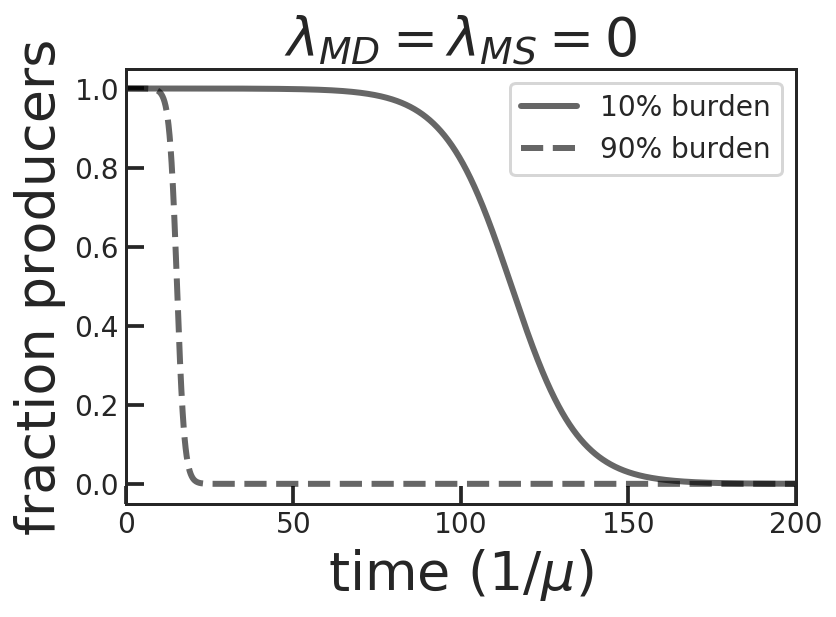

In [19]:
# Plot with legend for burden
fig, ax = plt.subplots()
ax.plot(t,naive_out_lowB[:,0]/naive_out_lowB.sum(axis=1),color='black',alpha=0.6,linewidth=3)
ax.plot(t,naive_out_highB[:,0]/naive_out_highB.sum(axis=1),'--',color='black',alpha=0.6,linewidth=3)
ax.set_xlim(0,200)
ax.legend(['10% burden','90% burden'])
ax.set_xlabel('time ($1/\mu$)')
ax.set_ylabel('fraction producers')
ax.set_title('$\lambda_{MD}=\lambda_{MS}=0$')
plt.savefig('./diff_vs_ds_noMDMS_legend2.pdf')
# ax.legend(['naive','diff','diff+select'])

Now we will run the simulations and generate the plot for Figure 1H, where we have now included the differentiation mutations and selection mutations.

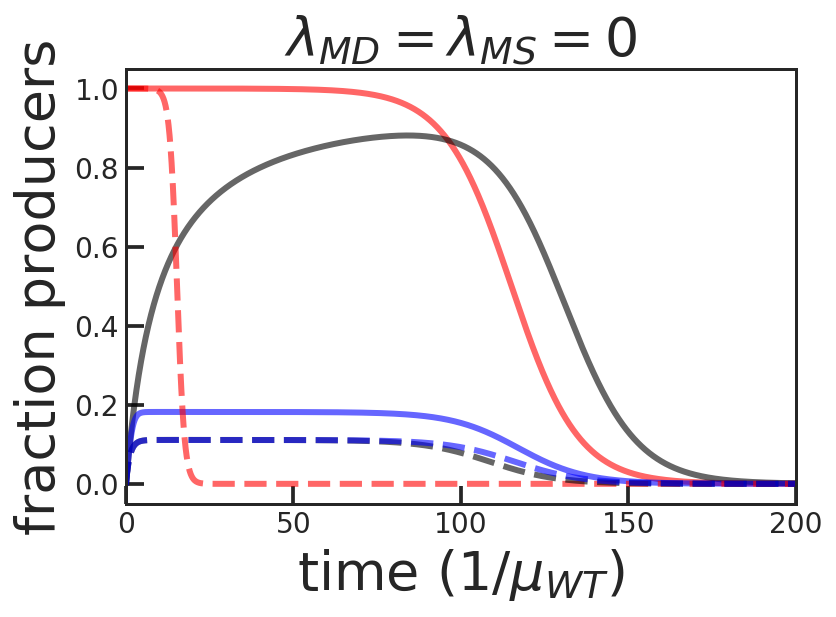

In [20]:
# Run simulations to compare naive vs. diff vs. diff+select with differentiation and selection mutations

# Parameters and starting conditions
progenitor_init = 1e7
t = np.linspace(0,24*10,24*100)
lam_diff = 0.1
n_div = 4
lam_MB = 1e-6
lam_MD = 1e-6
lam_MS = 1e-6
naive_c0 = np.array([progenitor_init,0])
diff_c0 = np.array([progenitor_init,0,0])
ds_c0 = np.concatenate((np.array([progenitor_init,0,0]),np.zeros(n_div+1)))

# Low burden specific parameters
mu_wt = 1
burden = 0.1
mu_N = mu_wt
mu_M = mu_wt
mu_P = mu_wt*(1-burden)




# Run simulations for low burden case for naive, differentiation, and terminal differentiation
naive_out_lowB = scipy.integrate.odeint(naive_noK, np.array([progenitor_init,0]), t, args=(mu_P, mu_N, lam_MB))
diff_out_lowB = run_diff_exponential(np.array([lam_diff]), mu_P=mu_P, mu_N=mu_N, mu_M=mu_M,lam_MB=lam_MB,
                                    lam_MD=lam_MD,progenitor_init=progenitor_init,t=t)

ds_out_lowB = run_diff_select_exponential(np.array([lam_diff]), np.array([n_div]), mu_wt=mu_wt, burden=burden, 
                                          lam_MB=lam_MB, lam_MD=lam_MD, lam_MS=lam_MS, progenitor_init=progenitor_init, 
                                          t=t,nodiv_ctot_count=False,endpoints_only=False)
# Plot low-burden simulations
fig, ax = plt.subplots()
ax.plot(t,naive_out_lowB[:,0]/naive_out_lowB.sum(axis=1),color=sns.color_palette()[0],alpha=0.6,linewidth=3)
ax.plot(t,diff_out_lowB['diff'].values,color=sns.color_palette()[1],alpha=0.6,linewidth=3)
ax.plot(t,ds_out_lowB['x_dp'].values+ds_out_lowB['x_mp'].values,color=sns.color_palette()[2],alpha=0.6,linewidth=3)


# High-burden specific parameters
mu_wt = 1
burden = 0.9
mu_N = mu_wt
mu_M = mu_wt
mu_P = mu_wt*(1-burden)
lam_MB = 1e-6

# Run simulations for high burden case for naive, differentiation, and terminal differentiation
naive_out_highB = scipy.integrate.odeint(naive_noK, np.array([progenitor_init,0]), t, args=(mu_P, mu_N, lam_MB))
diff_out_highB = run_diff_exponential(np.array([lam_diff]), mu_P=mu_P, mu_N=mu_N, mu_M=mu_M,lam_MB=lam_MB,
                                    lam_MD=lam_MD,progenitor_init=progenitor_init,t=t)

ds_out_highB = run_diff_select_exponential(np.array([lam_diff]), np.array([n_div]), mu_wt=mu_wt, burden=burden, 
                                          lam_MB=lam_MB, lam_MD=lam_MD, lam_MS=lam_MS, progenitor_init=progenitor_init, 
                                          t=t,nodiv_ctot_count=False,endpoints_only=False)

# Plot high burden simulations
ax.plot(t,naive_out_highB[:,0]/naive_out_highB.sum(axis=1),'--',color=sns.color_palette()[0],alpha=0.6,linewidth=3)
ax.plot(t,diff_out_highB['diff'].values,'--',color=sns.color_palette()[1],alpha=0.6,linewidth=3)
ax.plot(t,ds_out_highB['x_dp'].values+ds_out_highB['x_mp'].values,'--',color=sns.color_palette()[2],alpha=0.6,linewidth=3)

ax.set_xlim(0,200)
ax.set_xlabel('time ($1/\mu_{WT}$)')
ax.set_ylabel('fraction producers')
ax.set_title('$\lambda_{MD}=\lambda_{MS}=0$')
plt.savefig('./diff_vs_ds_1e6MDMS.pdf')